# 随机激光光谱深度学习Keras
1.14

## 导入所需的库

In [28]:
import graphviz
import keras.backend
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import *
from keras.losses import mean_squared_error
from keras.models import *
from keras.utils import plot_model
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# import pydot_ng as pydot
from tensorflow.keras.utils import plot_model
import cv2
np.random.seed(10)

## 导入光谱数据

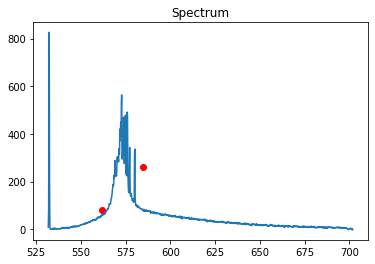

In [29]:
# 输入数据
sum_data = np.load("12.13-2_5000.npy")

# 作图查看
plt.figure()
plt.plot(sum_data[0, :, 0], sum_data[0, :, 1])
plt.title("Spectrum")

# 取点
# [start, end] = plt.ginput(2)
# x1, y1 = start[0], start[1]
# x2, y2 = end[0], end[1]

x1, y1 = 562, 82.5033333333331
x2, y2 = 585, 263.32476190476154
plt.scatter([x1, x2], [y1, y2], c="r")

Mat_crop分割长度：134


Text(0.5, 1.0, 'Crop Spectrum')

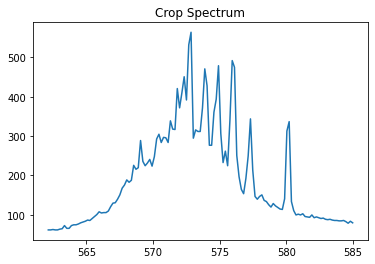

In [30]:
# 分割
index = (sum_data[0, :, 0] > x1) & (sum_data[0, :, 0] < x2)
Mat_crop = sum_data[:, index, :]

numChannels = Mat_crop.shape[1]
print("Mat_crop分割长度：{}".format(numChannels))  # 196

# 作图查看
plt.figure()
plt.plot(Mat_crop[0, :, 0], Mat_crop[0, :, 1])
plt.title("Crop Spectrum")

In [31]:
# 保留光谱值并竖向转置
DataY = np.squeeze(Mat_crop[:, :, 1])
frame = DataY.shape[0]
frame, DataY.shape

(5000, (5000, 134))

## 光谱归一化与标准化的对比

In [32]:
# Z-Score标准化的评估器实现方法  均按列转换

X = DataY  # 导入数据
scaler = StandardScaler()
train_x, test_x = train_test_split(
    X, train_size=int(0.8 * frame), test_size=int(0.2 * frame - 1), shuffle=False
)

# scaler.inverse_transform() 逆转换

# 0-1标准化的评估器实现方法

scaler = MinMaxScaler()
train_x_col_norm = scaler.fit_transform(X)  # 对比，列归一化

train_x_row_norm = scaler.fit_transform(X.T).T  # 对比，行归一化

# 一步执行在X_train上fit和transfrom两个操作
scaler = StandardScaler()
train_x_col_std = scaler.fit_transform(train_x)

train_x_row_std = scaler.fit_transform(train_x.T).T
test_x_row_std = scaler.fit_transform(
    test_x.T
).T  # 非通道，若以训练集的均值和标准差转换测试集--scaler.tansform,

# 赋值替代
train_x = train_x_row_std
test_x = test_x_row_std

Text(0.5, 1.0, 'Row_std Spectrum')

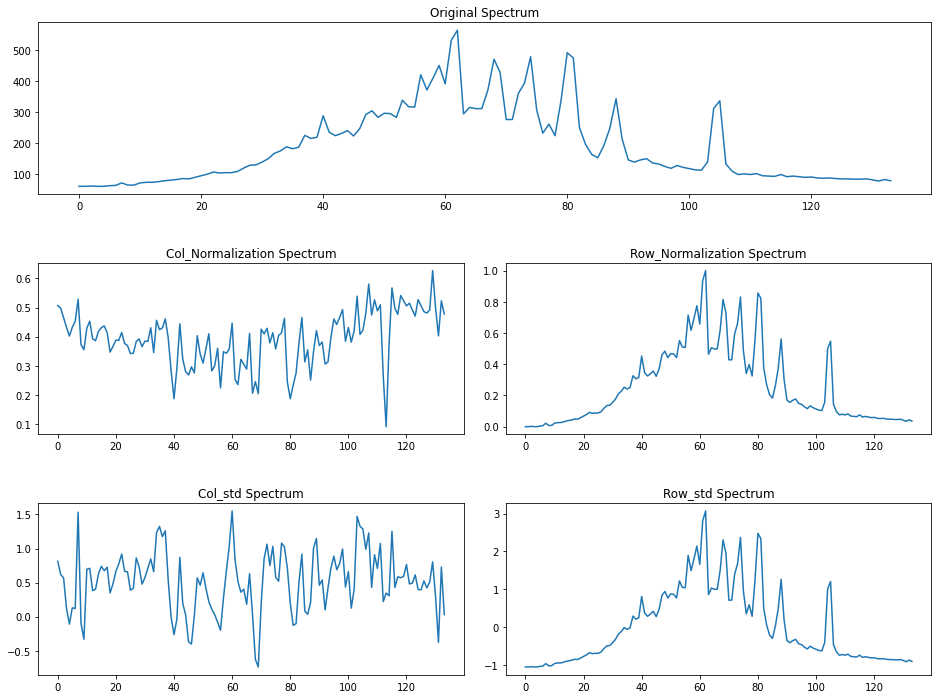

In [33]:
# 作图查看
fig = plt.figure(figsize=(16, 12))  # 宽，高
fig.subplots_adjust(hspace=0.4, wspace=0.1)  # 间距
# gs = fig.add_gridspec(2, 2) 一图占多位
# plt.subplot(gs[0,0])

plt.subplot2grid((3, 2), (0, 0), colspan=2)  # (行列分布)，（起始区），rowspan 列合并
plt.plot(X[0, :])  # 第一行
plt.title("Original Spectrum")

plt.subplot(323)
plt.plot(train_x_col_norm[0, :])  # 第一行
plt.title("Col_Normalization Spectrum")  # 列数据缩放到[0,1]范围内，缺点是受极值影响。

plt.subplot(324)
plt.plot(train_x_row_norm[0, :])  # 第一行
plt.title("Row_Normalization Spectrum")

plt.subplot(325)
plt.plot(train_x_col_std[0, :])  # 第一行
plt.title("Col_std Spectrum")  # 数据处理成均值为0，方差为1的数据。优点是受异常值影响较小

plt.subplot(326)
plt.plot(train_x_row_std[0, :])  # 第一行
plt.title("Row_std Spectrum")

In [34]:
# # 数据集标准化
# mu = np.mean(DataY, 0)  # 0,1方向
# sigma = np.std(DataY, 0)
# Data_stdn = (DataY - mu) / (sigma)   # DataY mu要满足列数相等
# Data_stdn = Data_stdn

# # 特征标准化（波形不变）
# mu = np.mean(DataY, 1)  # 0,1方向
# sigma = np.std(DataY, 1)
# Data_stdn = (DataY.T - mu) / (sigma)   #满足列数相等
# Data_stdn = Data_stdn.T

# mu.shape,Data_stdn.shape

# # 训练集与测试集
# train = Data_stdn[ 0 : int(0.9 * frame),:]  # float转int
# test = Data_stdn[ int(0.9 * frame) : frame,:]
# train.shape,test.shape

train_frame = train_x.shape[0]
test_frame = test_x.shape[0]
train_frame, test_frame

(4000, 999)

Text(0.5, 1.0, 'Standardization Spectrum')

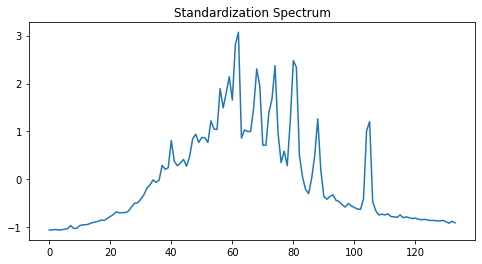

In [35]:
# 作图查看
plt.figure(figsize=(8, 4))
plt.plot(train_x[0, :])  # 第一行
plt.title("Standardization Spectrum")

## 以时间步重构三维数组

In [70]:
# 分批次
time_step = 32   #16 32
dataX, dataY = [], []
for i in range(train_frame - time_step):
    a = train_x[i : time_step + i, :]
    dataX.append(a)
    dataY.append(train_x[time_step + i, :])
train_X = np.array(dataX)
train_Y = np.array(dataY)  # .reshape(-1,numChannels,1)
print(train_X.shape)
print(train_Y.shape)

(3968, 32, 134)
(3968, 134)


In [71]:
testX, testY = [], []
for i in range(test_frame - time_step):
    a = test_x[i : time_step + i, :]
    testX.append(a)
    testY.append(test_x[time_step + i, :])
test_X = np.array(testX)
test_Y = np.array(testY)  # .reshape(-1,numChannels,1)
print(test_X.shape)
print(test_Y.shape)

# # 交错时间步
# sum_train_x = train[:, :-1]
# sum_train_y = train[:, 1: (train_frame + 1)]
#
# sum_test_x = test[:, :-1]
# sum_test_y = test[:, 1: (test_frame + 1)]

(967, 32, 134)
(967, 134)


## 构建神经网络层 Conv1D+BiLSTM+Attention

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32, 134)      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 32, 256)      103168      input_12[0][0]                   
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32, 256)      525312      conv1d[0][0]                     
__________________________________________________________________________________________________
permute_45 (Permute)            (None, 256, 32)      0           lstm[0][0]                       
___________________________________________________________________________________________

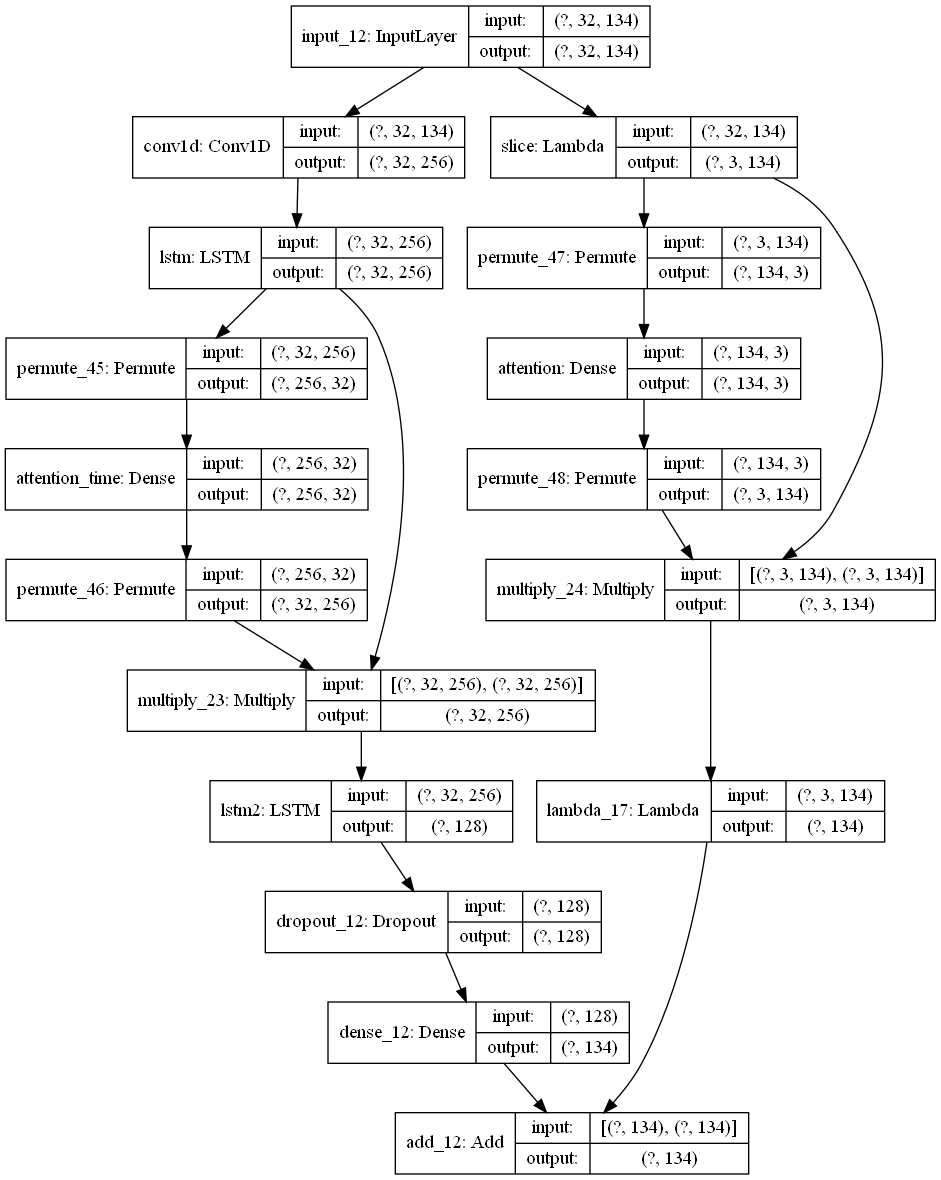

In [72]:
# Model式
lstm_units = 256
dropout = 0.05
pool_size=2

inputs = Input(shape=(time_step, numChannels))

model = Conv1D(filters=256, kernel_size=3, padding="causal", activation="relu", use_bias=True, name="conv1d")(inputs)  # 卷积层
# model=MaxPooling1D(pool_size)(model)#池化层
# model = Conv1D(filters=256, kernel_size=3, padding="causal", activation="relu", use_bias=True)(model)  # 卷积层
# model=MaxPooling1D(pool_size)(model)#池化层
model = LSTM(lstm_units, return_sequences=True, name="lstm")(model)

attention_time = Permute(dims=(2, 1))(model)
# attention_time = Dense(int(time_step/pool_size**2), activation="sigmoid", name="attention_time")(attention_time)  # 求解Attention权重
attention_time = Dense(time_step, activation="sigmoid", name="attention_time")(attention_time)  # 求解Attention权重
attention_time = Permute(dims=(2, 1))(attention_time)
model = Multiply()([model, attention_time])  # attention与LSTM对应数值相乘

model = LSTM(128, name="lstm2")(model)
model = Dropout(dropout)(model)  # droupout层

# model = Dense(64, activation="relu")(model)
model = Dense(numChannels)(model)

slice_length=3    
lambda_slice = Lambda(lambda x:x[:,time_step-slice_length:time_step+1,:], name="slice")(inputs)

attention_time3 = Permute(dims=(2, 1))(lambda_slice)
attention_time3 = Dense(slice_length, activation="softmax", name="attention")(attention_time3)  # 求解Attention权重
attention_time3 = Permute(dims=(2, 1))(attention_time3)
lambda0 = Multiply()([lambda_slice, attention_time3])  # attention与LSTM对应数值相乘

lambda_sum = Lambda(lambda x:keras.backend.sum(x,axis=1,keepdims=False))(lambda0)  # attention与LSTM对应数值相乘

# attention_time3 = Dense(numChannels, activation="sigmoid")(lambda_sum)  # 求解Attention权重
# lambda0 = Multiply()([lambda_sum, attention_time3])  # attention与LSTM对应数值相乘

# lambda0 = Lambda(lambda x:keras.backend.squeeze(x,axis=1))(lambda0)  # attention与LSTM对应数值相乘

# model = Add()([model,lambda1, lambda2,lambda3]) #activation="softmax"
# model = Add()([model,lambda_sum]) #activation="softmax"

# model = Dense(64)(model)

predictions = Add()([model,lambda_sum]) #activation="softmax"

# predictions = Dense(numChannels)(model)

# predictions = Dense(numChannels)(model)
# model = Reshape(target_shape=(numChannels,1))(model)
# predictions = TimeDistributed(Dense(1))(model)
model = Model(inputs=inputs, outputs=predictions)

# 配置训练模型
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
# 优化器选择：SGD,RMSprop,Adam,AdamW,Adadelta,Adagrad,Adamax,Adafactor,Nadam,Ftrl
model.summary()  # 展示模型结构

plot_model(model, show_shapes=True, show_layer_names=True)  # 展示输入输出表格 ,to_file='model.png'

In [73]:
# 训练模型，以 xx 个样本为一个 batch 进行迭代
history = model.fit(
    train_X,
    train_Y,
    epochs=15,
    batch_size=64, # 16 32 64
    validation_data=(test_X, test_Y),
    verbose=2,
    shuffle=True,
)

Train on 3968 samples, validate on 967 samples
Epoch 1/15
 - 12s - loss: 0.1437 - accuracy: 0.2056 - val_loss: 0.1327 - val_accuracy: 0.2285
Epoch 2/15
 - 12s - loss: 0.1341 - accuracy: 0.2124 - val_loss: 0.1214 - val_accuracy: 0.2368
Epoch 3/15
 - 12s - loss: 0.1216 - accuracy: 0.2240 - val_loss: 0.1127 - val_accuracy: 0.2389
Epoch 4/15
 - 12s - loss: 0.1151 - accuracy: 0.2235 - val_loss: 0.1105 - val_accuracy: 0.2306
Epoch 5/15
 - 13s - loss: 0.1111 - accuracy: 0.2281 - val_loss: 0.1058 - val_accuracy: 0.2327
Epoch 6/15
 - 12s - loss: 0.1065 - accuracy: 0.2359 - val_loss: 0.1031 - val_accuracy: 0.2296
Epoch 7/15
 - 12s - loss: 0.1026 - accuracy: 0.2440 - val_loss: 0.1000 - val_accuracy: 0.2389
Epoch 8/15
 - 12s - loss: 0.0996 - accuracy: 0.2553 - val_loss: 0.0994 - val_accuracy: 0.2441
Epoch 9/15
 - 12s - loss: 0.0981 - accuracy: 0.2555 - val_loss: 0.0976 - val_accuracy: 0.2347
Epoch 10/15
 - 13s - loss: 0.0964 - accuracy: 0.2593 - val_loss: 0.0982 - val_accuracy: 0.2451
Epoch 11/15


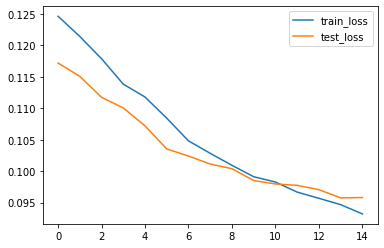

In [40]:
# 可视化进度
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="test_loss")
plt.legend()
plt.show()

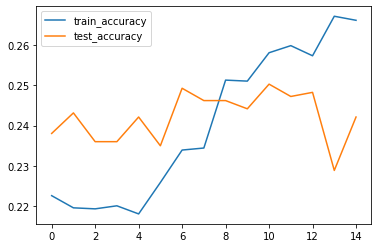

In [67]:
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="test_accuracy")
plt.legend()
plt.show()

## 预测光谱数据

In [74]:
# 在测试集上的预测
test_Y_predict = model.predict(test_X)
test_Y_predict.shape, test_Y.shape

((967, 134), (967, 134))

In [75]:
np.save('test_Y_article',test_Y)
np.save('test_Y_article_predict',test_Y_predict)
from scipy import io
mat=np.load('test_Y_article.npy')
io.savemat('test_Y_134_32.mat', {'test_Y_134_32': mat})
mat1=np.load('test_Y_article_predict.npy')
io.savemat('test_Y_134_32_predict.mat', {'test_Y_134_32_predict': mat1})

Text(0.5, 1.0, 'Test Data 4')

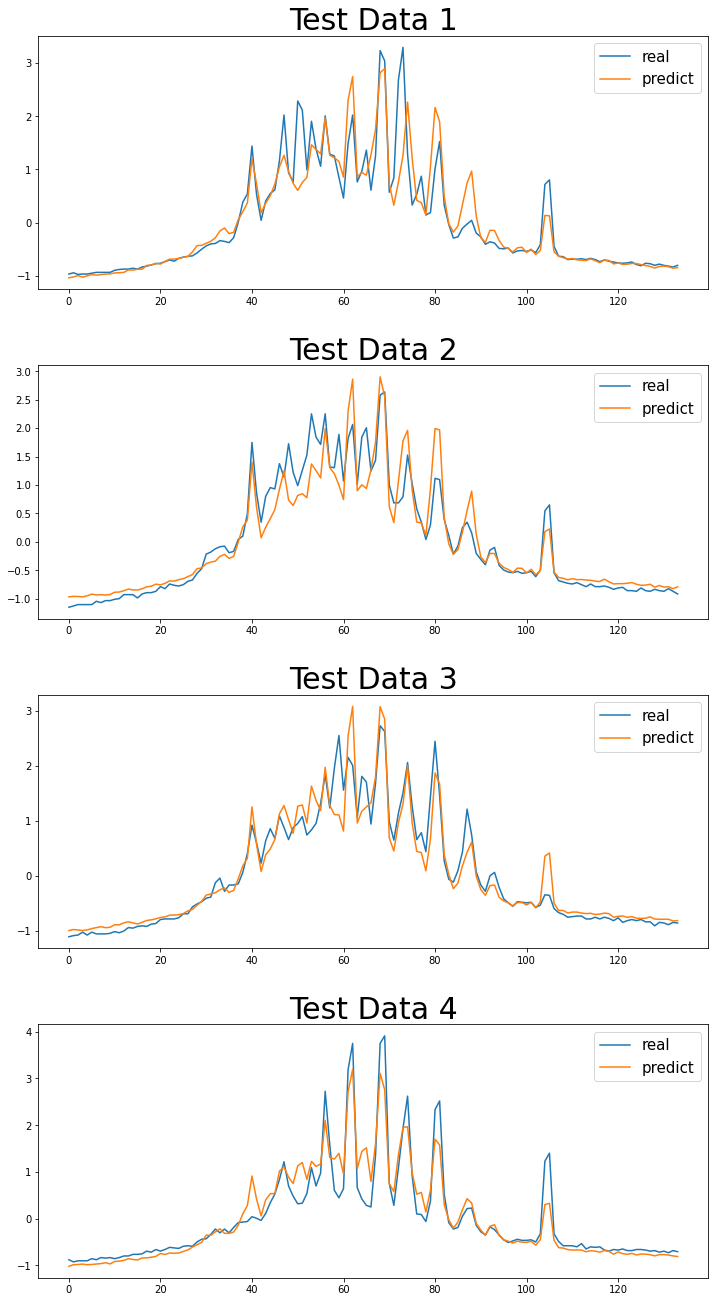

In [43]:
fig = plt.figure(figsize=(16,32))  # 宽，高
fig.subplots_adjust(hspace=0.3, wspace=0.1,top=3)  # 间距
plt.subplot(411)
draw = pd.concat([pd.DataFrame(test_Y[0, :]), pd.DataFrame(test_Y_predict[0, :])], axis=1)
draw.iloc[:, 0].plot(figsize=(12, 6))
draw.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Test Data 1", fontsize="30")  # 添加标题

plt.subplot(412)
draw2 = pd.concat([pd.DataFrame(test_Y[1, :]), pd.DataFrame(test_Y_predict[1, :])], axis=1)
draw2.iloc[:, 0].plot(figsize=(12, 6))
draw2.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Test Data 2", fontsize="30")  # 添加标题

plt.subplot(413)
draw2 = pd.concat([pd.DataFrame(test_Y[2, :]), pd.DataFrame(test_Y_predict[2, :])], axis=1)
draw2.iloc[:, 0].plot(figsize=(12, 6))
draw2.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Test Data 3", fontsize="30")  # 添加标题

plt.subplot(414)
draw2 = pd.concat([pd.DataFrame(test_Y[3, :]), pd.DataFrame(test_Y_predict[3, :])], axis=1)
draw2.iloc[:, 0].plot(figsize=(12, 6))
draw2.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Test Data 4", fontsize="30")  # 添加标题

Text(0.5, 1.0, 'x=100')

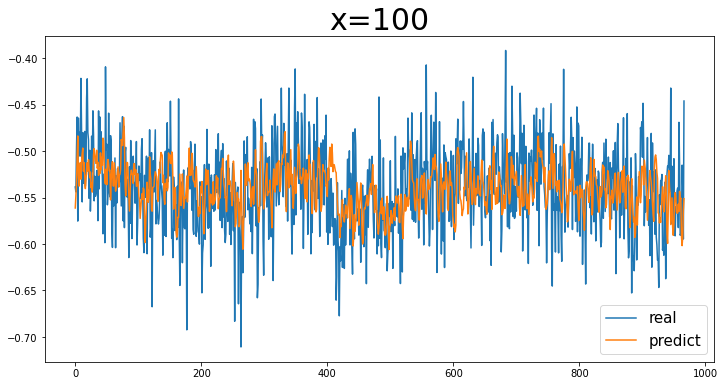

In [46]:
draw2 = pd.concat([pd.DataFrame(test_Y[:,100]), pd.DataFrame(test_Y_predict[:,100])], axis=1)
draw2.iloc[:, 0].plot(figsize=(12, 6))
draw2.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("x=100", fontsize="30")  # 添加标题

In [44]:
# 输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# 平均绝对误差（Mean Absolute Error，MAE）

# 均方误差（Mean Square Error，MSE）
# 平均绝对百分比误差（Mean Absolute Percentage Error，MAPE）
print("测试集上的")
print("MAE:{}".format(mean_absolute_error(test_Y_predict, test_Y)))
print("MSE:{}".format(mean_squared_error(test_Y_predict, test_Y)))
print("MAPE:{}".format(mape(test_Y_predict, test_Y)))

测试集上的
MAE:0.17273612307541225
MSE:0.09579544079832578
MAPE:63.079907597183194


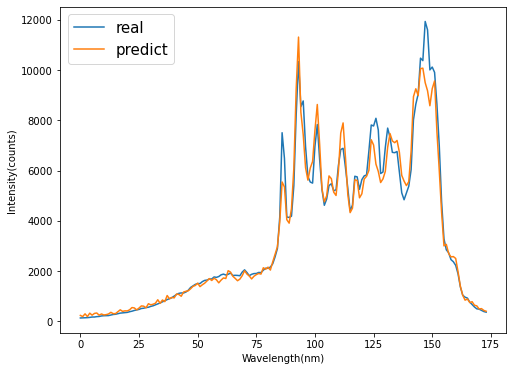

In [22]:
# 去标准化
indexY = test_Y.shape[0]
scaler.fit(DataY[frame - indexY : frame + 1, :].T)
test_Y_inv = scaler.inverse_transform(test_Y.T).T
test_Y_predict_inv = scaler.inverse_transform(test_Y_predict.T).T

draw2 = pd.concat([pd.DataFrame(test_Y_inv[1, :]), pd.DataFrame(test_Y_predict_inv[1, :])], axis=1)
draw2.iloc[:, 0].plot(figsize=(8, 6))
draw2.iloc[:, 1].plot(figsize=(8, 6))
ax.set_xticklabels()
plt.xlabel('Wavelength(nm)')
plt.ylabel('Intensity(counts)')
plt.legend(("real", "predict"), fontsize="15",loc='upper left')
# plt.title("Inverse Transform Test Data 2", fontsize="30")  # 添加标题

In [27]:
test_Y1000=test_Y
np.save('test_Y1000',test_Y1000)
from scipy import io
mat1=np.load('test_Y1000.npy')
io.savemat('test_Y1000.mat', {'test_Y1000': mat1})

test_Y_predict1000=test_Y_predict
np.save('test_Y_predict1000',test_Y_predict1000)
from scipy import io
mat1=np.load('test_Y_predict1000.npy')
io.savemat('test_Y_predict1000.mat', {'test_Y_predict1000': mat1})

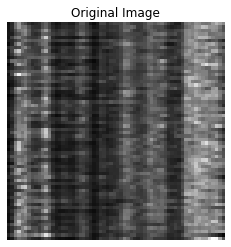

(64, 64)

In [23]:
Y=test_Y[0:64,90:154]
Y_predict=test_Y_predict[0:64,90:154]
plt.figure()
plt.imshow(Y, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()
Y.shape

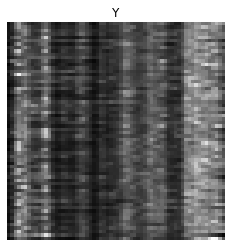

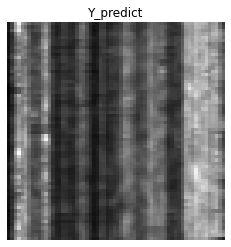

In [34]:
# Y=cv2.resize(Y,(64,64))
# Y_predict=cv2.resize(Y_predict,(64,64))
plt.figure()
plt.imshow(Y, cmap='gray')
plt.title('Y')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(Y_predict, cmap='gray')
plt.title('Y_predict')
plt.axis('off')
plt.show()

def fun_Arnold(I,a,b,n):
    [x,y]=I.shape
    encrypt=np.zeros((x,y))

    for num in range(n):
        for i in range(x):
            for j in range(y):  # i j从0开始
                xx=np.mod(1*i+b*j,x)
                yy=np.mod(a*i+(a*b+1)*j,y)
                encrypt[xx,yy]=I[i,j]
        I=encrypt
    return I

In [25]:
fai_Arnold=fun_Arnold(Y,1,1,4)
plt.imshow(fai_Arnold, cmap='gray')
plt.axis('off')
plt.show()

fai_Arnold2=fun_Arnold(Y_predict,1,1,4)
plt.imshow(fai_Arnold2, cmap='gray')
plt.axis('off')
plt.show()

NameError: name 'fun_Arnold' is not defined

In [ ]:
np.zeros((64,64))

In [ ]:
def fun_PTFT(fai1):
    I=cv2.imread("lena64.bmp", 0)

    RP1 = np.exp(1j * 2 * np.pi * fai1)
    RP2 = np.exp(1j * 2 * np.pi * fai1.T)
    IF1=np.fft.fft2(I*RP1);
    g1=abs(IF1);

    IF2=np.fft.ifft2(g1*RP2);
    g=abs(IF2);

    P2=np.exp(1j*np.angle(np.fft.fft2(I*RP1))); 
    P1=np.exp(1j*np.angle(np.fft.ifft2(g1*RP2)));

    g1=abs(np.fft.fft2(g*P1));
    recover=abs(np.fft.ifft2(g1*P2));
    return g

g=fun_PTFT(fai_Arnold)
plt.imshow(g, cmap='gray')
plt.axis('off')
plt.show()

def fun_PTFT_Recover(g,fai1):
    I=cv2.imread("lena64.bmp", 0)

    RP1 = np.exp(1j * 2 * np.pi * fai1)
    RP2 = np.exp(1j * 2 * np.pi * fai1.T)
    IF1=np.fft.fft2(I*RP1);
    g1=abs(IF1);
    
    P2=np.exp(1j*np.angle(np.fft.fft2(I*RP1))); 
    P1=np.exp(1j*np.angle(np.fft.ifft2(g1*RP2)));

    g1=abs(np.fft.fft2(g*P1));
    recover=abs(np.fft.ifft2(g1*P2));
    return recover

recover_Y=fun_PTFT_Recover(g,fai_Arnold)
plt.imshow(recover_Y, cmap='gray')
plt.axis('off')
plt.show()

recover_Y_predict=fun_PTFT_Recover(g,fai_Arnold2)
plt.imshow(recover_Y_predict, cmap='gray')
plt.axis('off')
plt.show()

In [35]:
Y
np.save('Y1',Y)
np.save('Y_predict',Y_predict)
from scipy import io
mat=np.load('Y1.npy')
io.savemat('Y1.mat', {'Y1': mat})
mat1=np.load('Y_predict.npy')
io.savemat('Y_predict.mat', {'Y_predict': mat1})

In [ ]:
cv2.imwrite('Y.bmp',Y)
cv2.imwrite('Y_predict.bmp',Y_predict)

In [ ]:
cv2.imwrite('recover_Y.png',recover_Y)
cv2.imwrite('recover_Y_predict.png',recover_Y_predict)